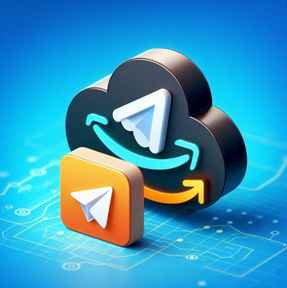

**Pipeline de Dados do Telegram**

1. Contexto;
2. Telegram;
3. Bot API;
4. Dados;
5. Ingestão;
6. ETL;
7. Apresentação;
8. Conclusão.

---

## 1\. Contexto

### **1.1. Chatbot**

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

### **1.2. Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

### **1.3. Arquitetura**

Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um **chatbot** para responder perguntas como:

1. Qual o horário que os usuários mais acionam o *bot*?
1. Qual o problema ou dúvida mais frequente?
1. O *bot* está conseguindo resolver os problemas ou esclarecer as dúvidas?
1. Etc.

Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

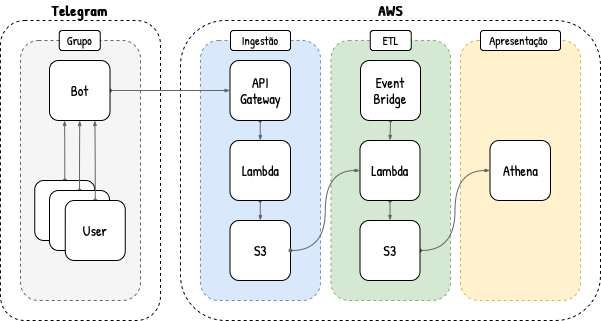

 - **Telegram**

O `Telegram` representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um *bot* e redirecionadas via *webhook* do *backend* do aplicativo para um *endpoint* (endereço *web* que aceita requisições HTTP) exposto pelo `AWS API Gateway`. As mensagens trafegam no corpo ou *payload* da requisição.

 - **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu *payload* é recebia pelo `AWS API Gateway` que, por sua vez, as redireciona para o `AWS Lambda`, servindo assim como seu gatilho. Já o `AWS Lambda` recebe o *payload* da requisição em seu parâmetro *event*, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o *payload*) e o armazena no `AWS S3` particionado por dia.

 - **AWS | ETL**

Uma vez ao dia, o `AWS Event Bridge` aciona o `AWS Lambda` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no `AWS S3` particionado por dia.

 - **AWS | Apresentação**

Por fim, uma tabela do `AWS Athena` é apontada para o *bucket* do `AWS S3` que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de *insights*.

## 2\. Telegram

O **Telegram** representa a fonte transacional de dados do nosso *pipeline* de dados. Nesta etapa, criei um grupo e um **bot** e adicionando-o ao grupo recém criado. O *bot* então captará **todas** as mensagens enviadas no grupo. As mensagens pode ser acessadas através da API (*application programming interface*) de *bots* dos **Telegram**.

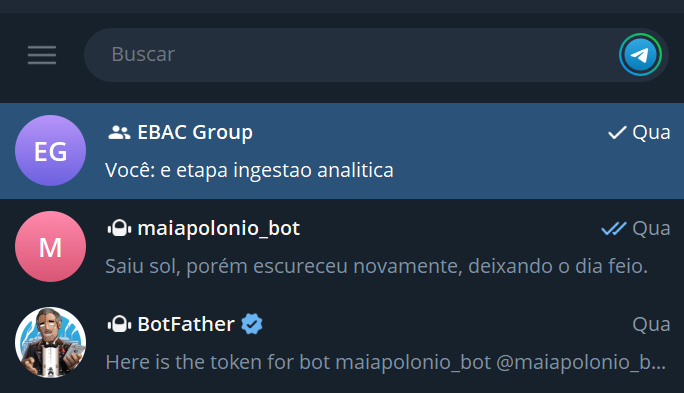

**3. Bot API**

As mensagens captadas por um *bot* podem ser acessadas via API. A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do *bot*.

In [ ]:
from getpass import getpass

token = getpass()

··········


A `url` base é comum a todos os métodos da API.

In [ ]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

- **getMe**

O método `getMe` retorna informações sobre o *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot7275963197:AAFp99e6-ZnFvr923puoQYhwjA5RVtLDLEI/getMe
{
  "ok": true,
  "result": {
    "id": 7275963197,
    "is_bot": true,
    "first_name": "maiapolonio_bot",
    "username": "maiapolonio_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false
  }
}


 - **getUpdates**

O método `getMe` retorna as mensagens captadas pelo *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 869639975,
      "message": {
        "message_id": 6,
        "from": {
          "id": 854168255,
          "is_bot": false,
          "first_name": "Fernanda",
          "last_name": "Polonio",
          "language_code": "pt-br"
        },
        "chat": {
          "id": 854168255,
          "first_name": "Fernanda",
          "last_name": "Polonio",
          "type": "private"
        },
        "date": 1720617201,
        "text": "Tudo bem?"
      }
    },
    {
      "update_id": 869639976,
      "message": {
        "message_id": 7,
        "from": {
          "id": 854168255,
          "is_bot": false,
          "first_name": "Fernanda",
          "last_name": "Polonio",
          "language_code": "pt-br"
        },
        "chat": {
          "id": 854168255,
          "first_name": "Fernanda",
          "last_name": "Polonio",
          "type": "private"
        },
        "date": 1720617235,
        "text": "Ola, mundo

## 4\. Dados

Antes de avançar para etapa analítica, vamos trabalhar na manipulação dos dados de mensagens do **Telegram**.

### **4.1. Mensagem**

Uma mensagem recuperada via API é um dado semi-estruturado no formato JSON com algumas chaves mandatórias e diversas chaves opcionais, estas últimas presentes (ou não) dependendo do tipo da mensagem. Por exemplo, mensagens de texto apresentam a chave `text` enquanto mensagens de áudio apresentam a chave `audio`. Neste projeto vamos focar em mensagens do tipo texto, ou seja, vamos ingerir as chaves mandatórias e a chave `text`.

> **Nota**: A lista completa das chaves disponíveis pode ser encontrada na documentação neste [link](https://core.telegram.org/bots/api#message).

 - Exemplo:

In [ ]:
%%writefile telegram.json
{
    "update_id": 123,
    "message": {
        "message_id": 1,
        "from": {
            "id": 321,
            "is_bot": false,
            "first_name": "Fernanda"
        },
        "chat": {
            "id": -789,
            "type": "group"
        },
        "date": 1640995200,
        "text": "Ola, mundo!"
    }
}

Overwriting telegram.json


 - Descrição:

| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

### **4.2. Wrangling**

Vamos denormalizar o conteúdo da mensagem semi-estruturado no formato JSON utilizando apenas Python nativo, ou seja, sem o auxílio de pacotes, como Pandas.

Para começar, vamos carregar o arquivo `telegram.json` utilizando o pacote nativo `json`.

In [ ]:
import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  data = data["message"]

In [ ]:
print(json.dumps(data, indent=2))

{
  "message_id": 1,
  "from": {
    "id": 321,
    "is_bot": false,
    "first_name": "Fernanda"
  },
  "chat": {
    "id": -789,
    "type": "group"
  },
  "date": 1640995200,
  "text": "Ola, mundo!"
}


Vamos então utilizar um laço de repetição para varrer todas as chaves do arquivo e selecionar apenas as de interesse. Caso a mensagem não possua a chave `text`, ela será criada com o valor igual a `None`. Além disso, vamos adicionar duas chaves de tempo para indicar o momento em que o dado foi processado: `context_date` e `context_timestamp`.

In [ ]:
from datetime import datetime

# Formatação do horário e hora
date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()

# Laço de repetição

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [ ]:
for k, v in parsed_data.items():
  print(f"{k}: {v}")

message_id: [1]
user_id: [321]
user_is_bot: [False]
user_first_name: ['Fernanda']
chat_id: [-789]
chat_type: ['group']
date: [1640995200]
text: ['Ola, mundo!']
context_date: ['2024-07-10']
context_timestamp: ['2024-07-10 13:40:40']


Por fim, vamos utilizar o pacote Python PyArrow para criar uma tabela com os dados processado que, posteriormente, pode ser facilmente persistida em um arquivo no formato Apache Parquet.

In [ ]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

In [ ]:
table

pyarrow.Table
message_id: int64
user_id: int64
user_is_bot: bool
user_first_name: string
chat_id: int64
chat_type: string
date: int64
text: string
context_date: string
context_timestamp: string
----
message_id: [[1]]
user_id: [[321]]
user_is_bot: [[false]]
user_first_name: [["Fernanda"]]
chat_id: [[-789]]
chat_type: [["group"]]
date: [[1640995200]]
text: [["Ola, mundo!"]]
context_date: [["2024-07-10"]]
context_timestamp: [["2024-07-10 13:40:40"]]

## 5\. Ingestão

A etapa de **ingestão** é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (*schema*). Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos, no formato JSON.

Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Poder ser conduzida da seguinte forma:


 - **Batch**: blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;
 - **Streaming**: dados são ingeridos conforme são produzidos e disponibilizados.

No projeto, as mensagens capturadas pelo *bot* podem ser ingeridas através da API *web* de *bots* do **Telegram**, portanto são fornecidos no formato JSON. Como o **Telegram** retem mensagens por apenas 24h em seus servidores, a ingestão via **streaming** é a mais indicada. Para que seja possível esse tipo de **ingestão** seja possível, vamos utilizar um *webhook* (gancho *web*), ou seja, vamos redirecionar as mensagens automaticamente para outra API *web*.

Sendo assim, precisamos de um serviço da AWS que forneça um API *web* para receber os dados redirecionados, o `AWS API Gateway` (documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). Dentre suas diversas funcionalidades, o `AWS API Gateway` permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conecta-lo ao `AWS Lambda`, que pode sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

> Sistemas que reagem a eventos são conhecidos como *event-driven*.

Portanto, precisamos:

 - Criar um *bucket* no `AWS S3`;
 - Criar uma função no `AWS Lambda`;
 - Criar uma API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**.

### **5.1. AWS S3**

Na etapa de **ingestão**, o `AWS S3` tem a função de passivamente armazenar as mensagens captadas pelo *bot* do **Telegram** no seu formato original: JSON. Para tanto, basta a criação de um *bucket*. Como padrão, vamos adicionar o sufixo `-raw` ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

**Bucket no AWS S3 - Data Lake Raw**

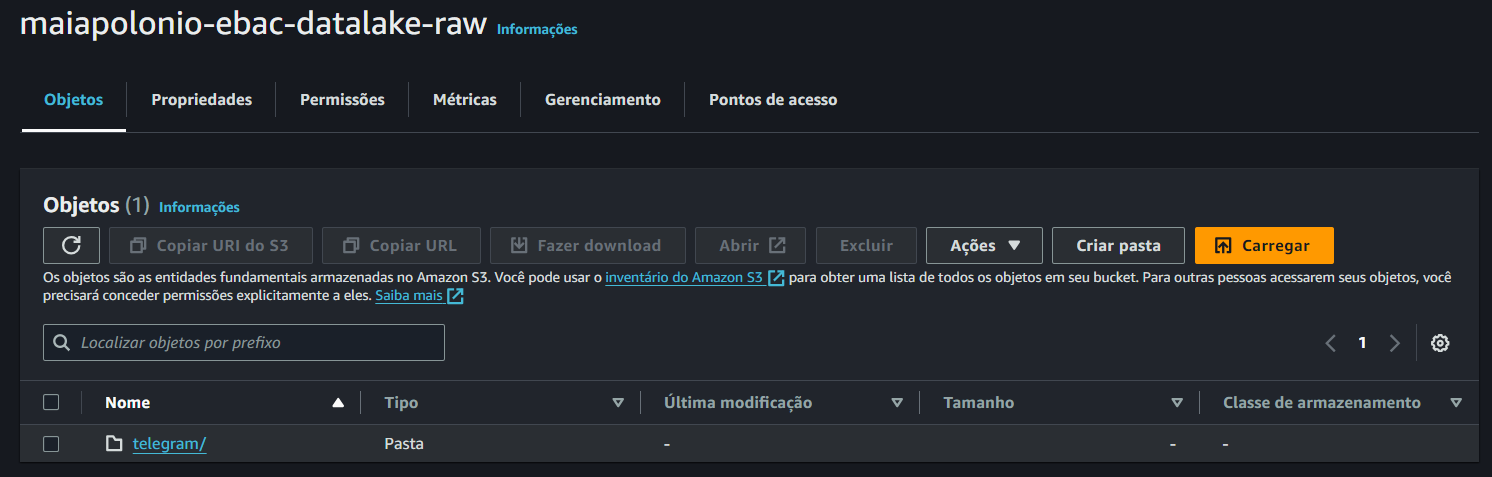

### **5.2. AWS Lambda**

Na etapa de **ingestão**, o `AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo *bot* do **Telegram** em um *bucket* do `AWS S3`. Para tanto vamos criar uma função que opera da seguinte forma:

 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

> **Nota**: No **Telegram**, restringimos a opção de adicionar o *bot* a grupos, contudo, ainda é possível iniciar uma conversa em um *chat* privado.

**Função Lambda Criada**

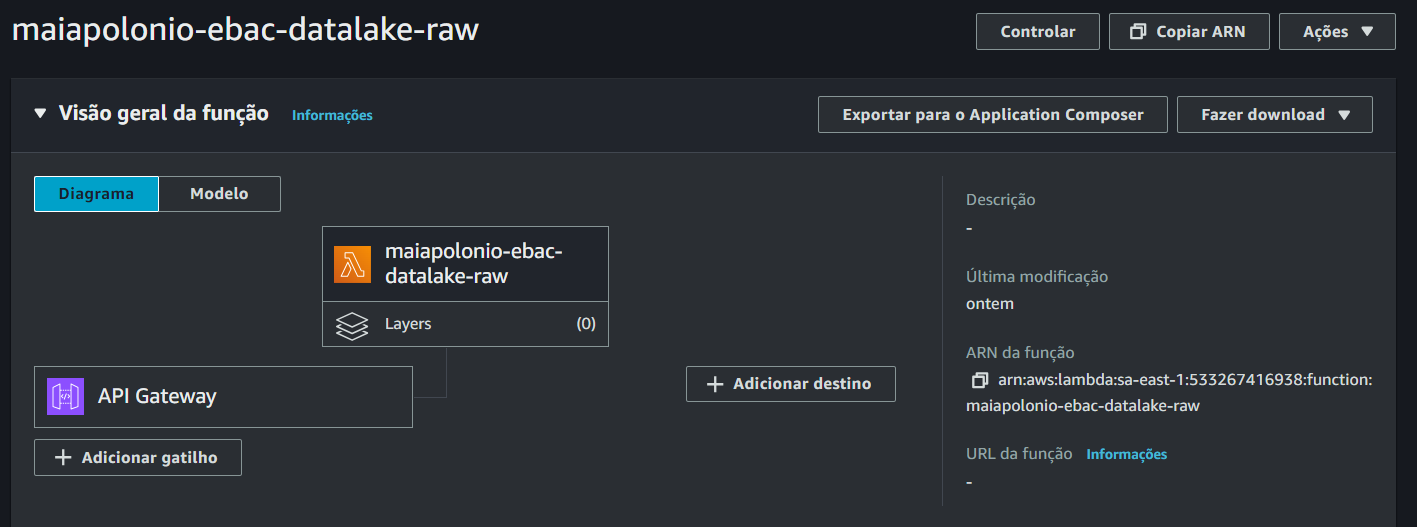

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

 - **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do *bucket* do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

> **Nota**: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.

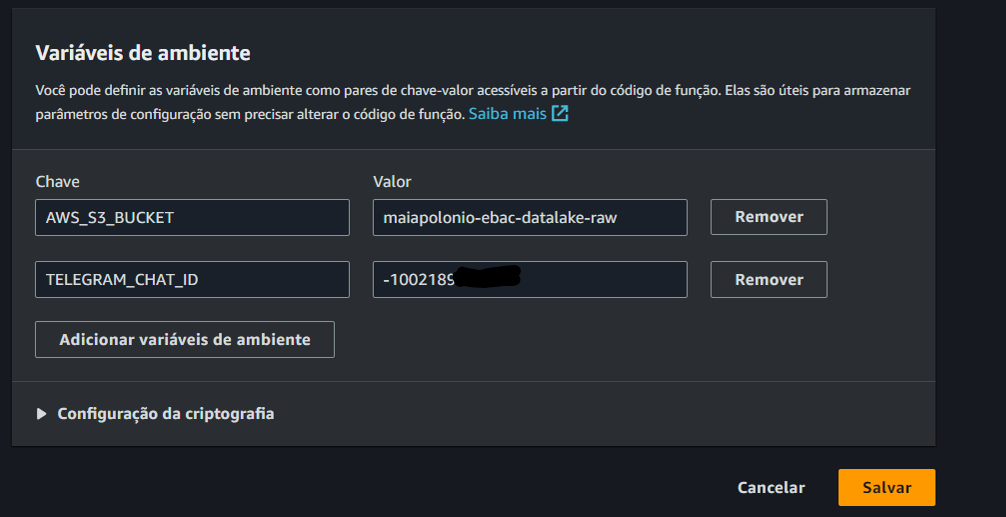

 - **Permissão**

Por fim, precisamos adicionar a permissão de escrita no *bucket* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

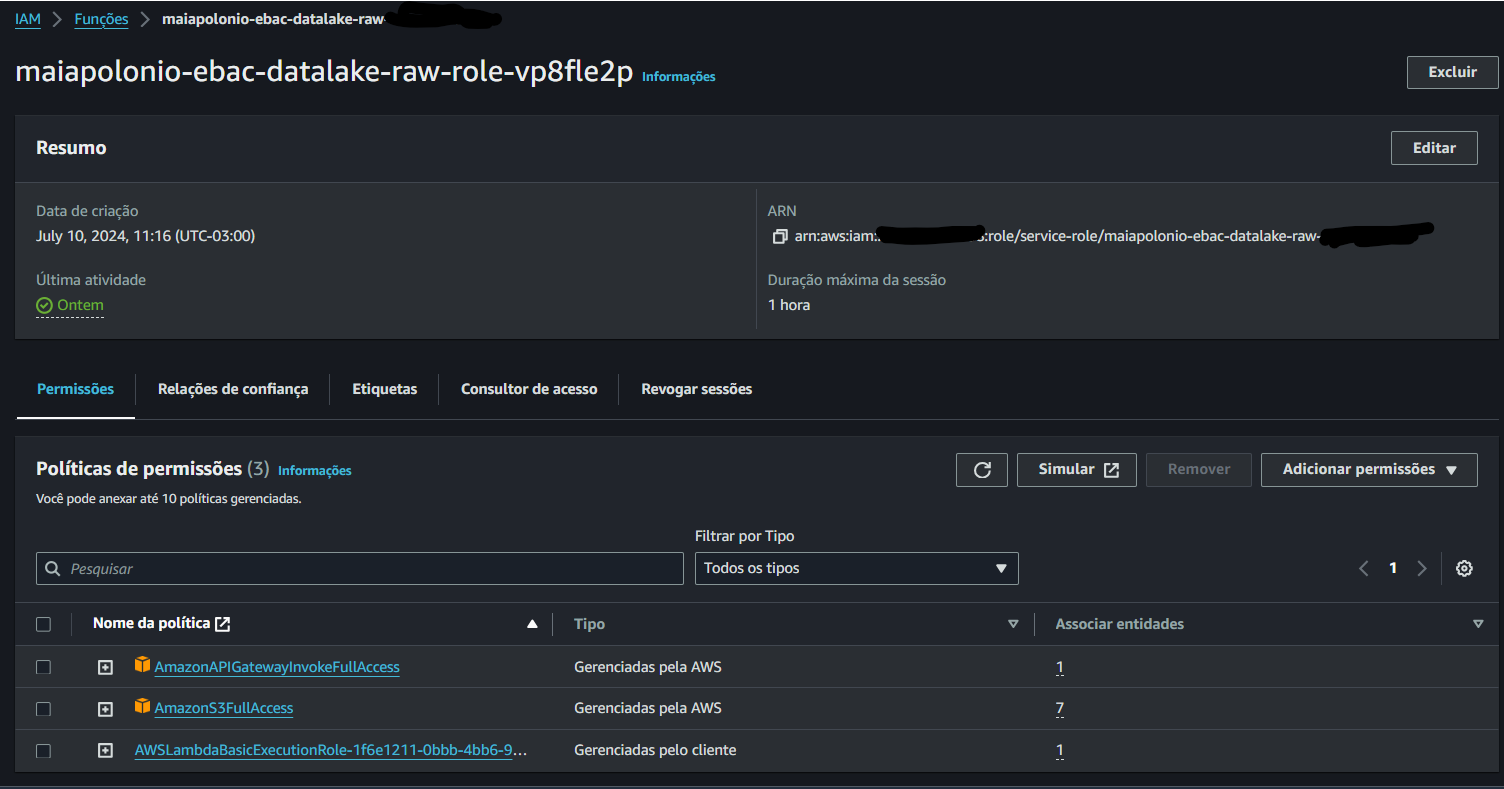

**Teste da Função**

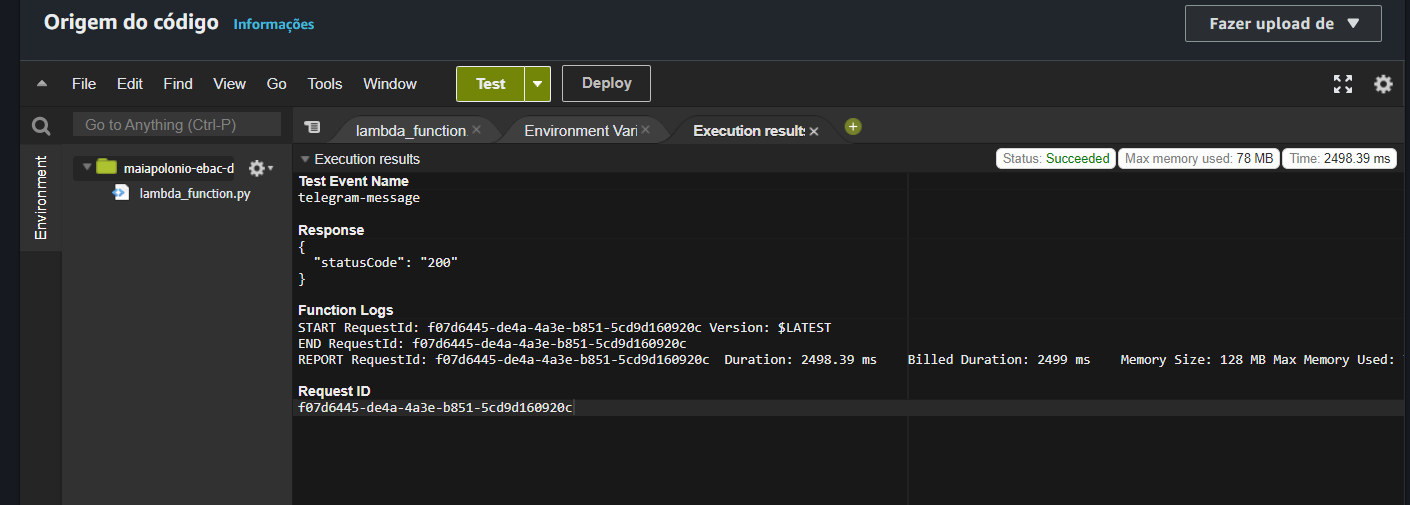

**Dado armazenado no bucket do AWS S3 após a execução da função Lambda**

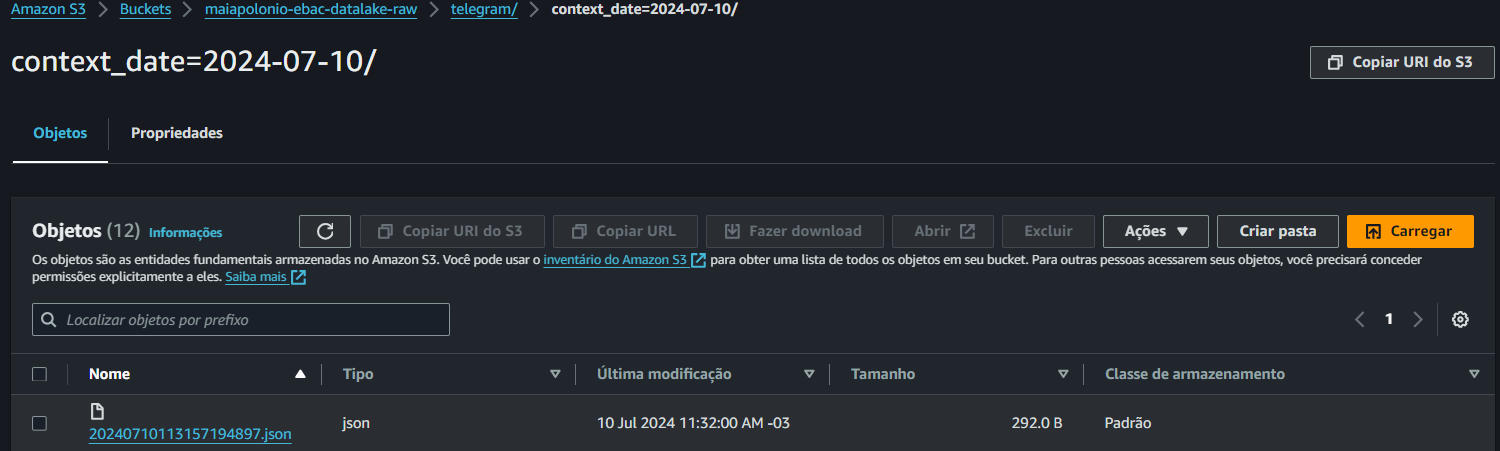

### **5.3. AWS API Gateway**

Na etapa de **ingestão**, o `AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto vamos criar uma API e configurá-la como gatilho da função do `AWS Lambda`:

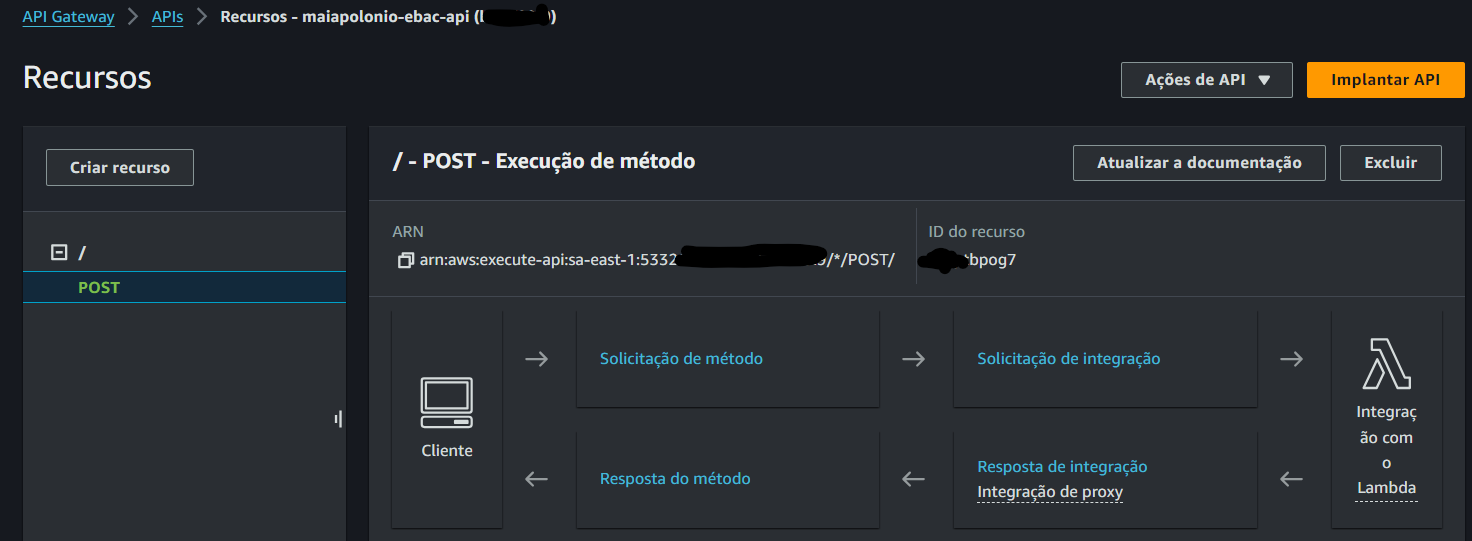

**Teste**

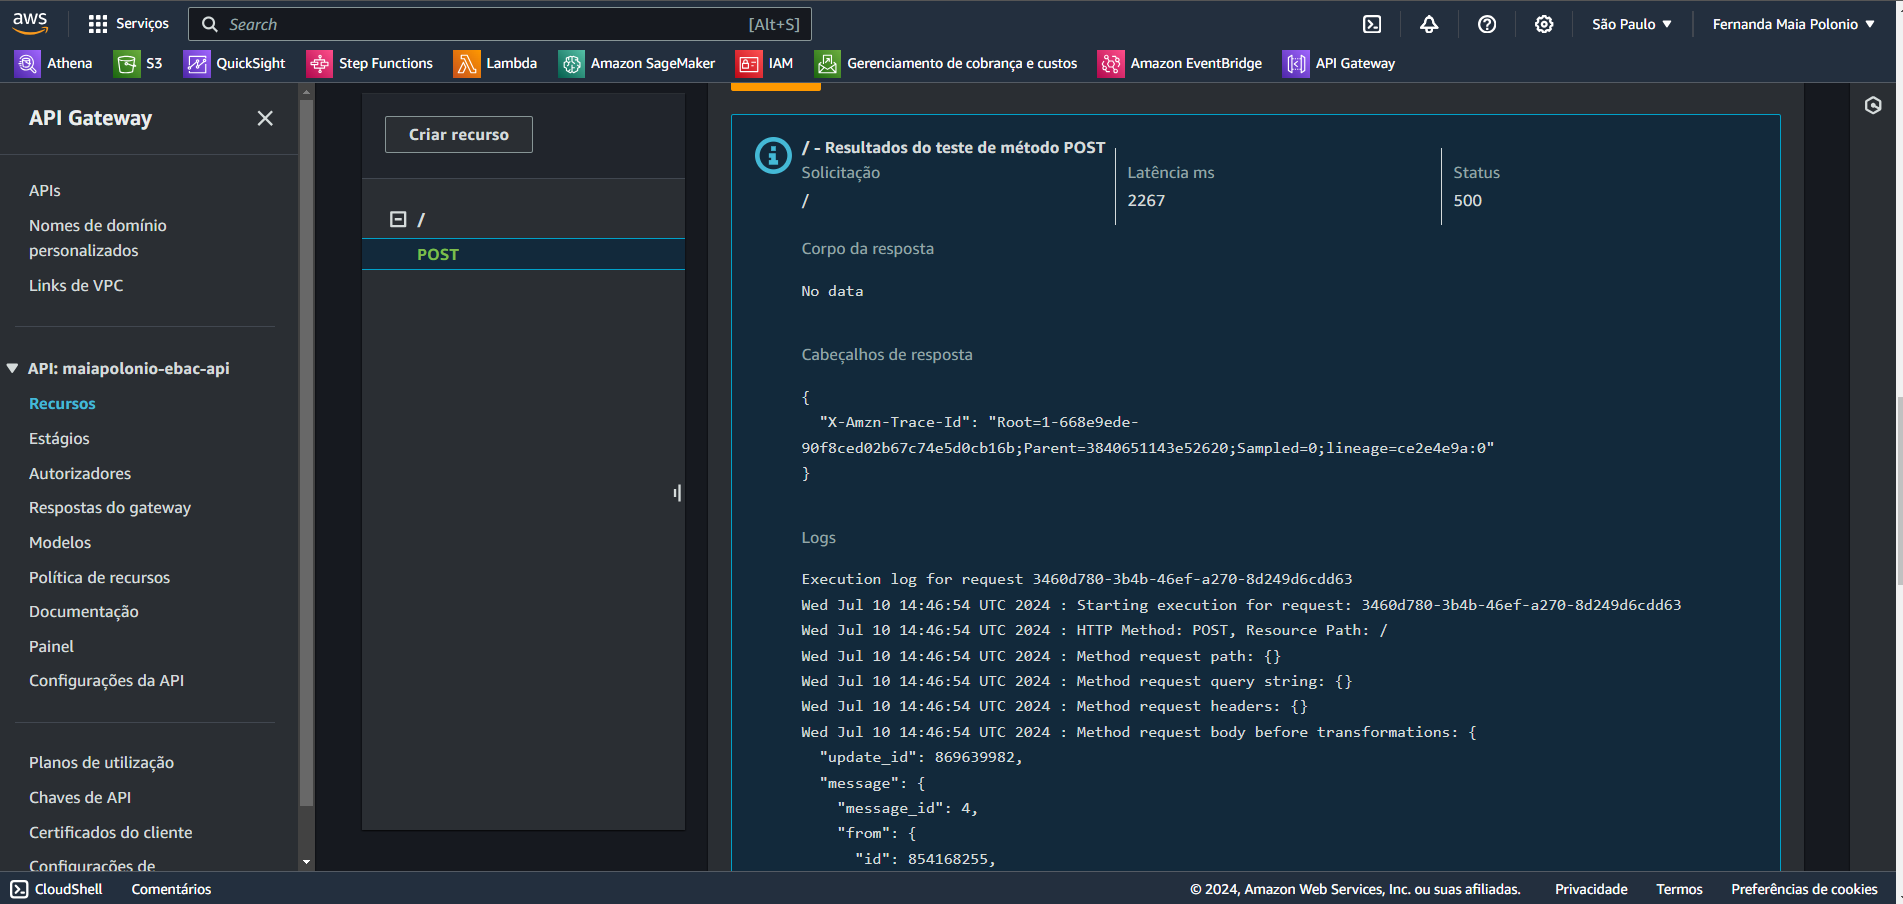

**Ingetar a URL do deploy**

In [ ]:
aws_api_gateway_url = getpass()

### **5.4. Telegram**

Vamos configurar o *webhook* para redirecionar as mensagens para a `url` do `AWS API Gateway`.

 - **setWebhook**

O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do paramametro `url`.

> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

 - **getWebhookInfo**

O método `getWebhookInfo` retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

### **6. ETL (Extraction, transformation and load)**

A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de *data wrangling*.

Para isso, vamos utilizar uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do `AWS Event Bridge` como gatilho diáro da função.

### **6.1. AWS S3**

Na etapa de **ETL**, o `AWS S3` tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet.

**Bucket criado para receber o arquivo processado no formato Apache Parquet.**

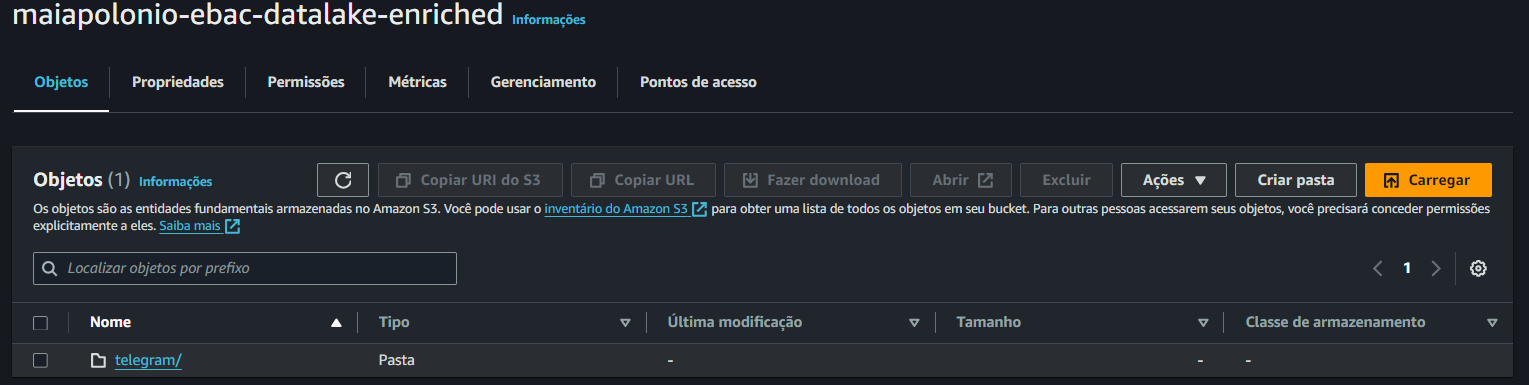

### **6.2. AWS Lambda**

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

> **Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

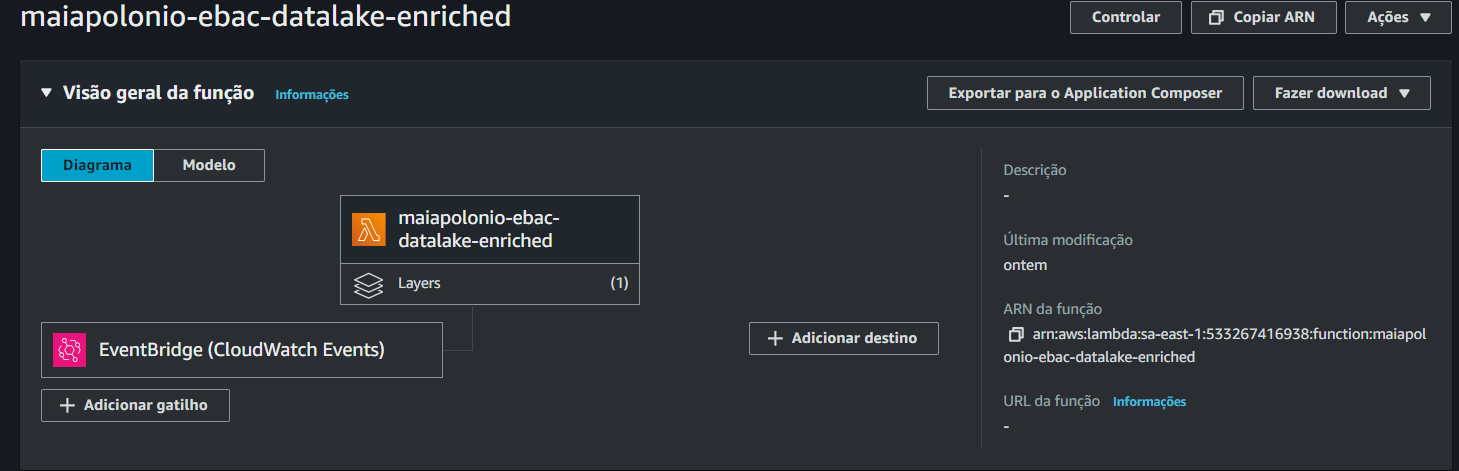

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*.

Junto ao código acima, temos que adicionar um laço de repetição para varrer todas as chaves do arquivo e selecionar apenas a text, que é a única de interesse deste projeto. Caso a mensagem não possua a chave text, ela será criada com o valor None.

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

**Arquivo carregado no bucket do S3 (enriched) no formato Parquet**

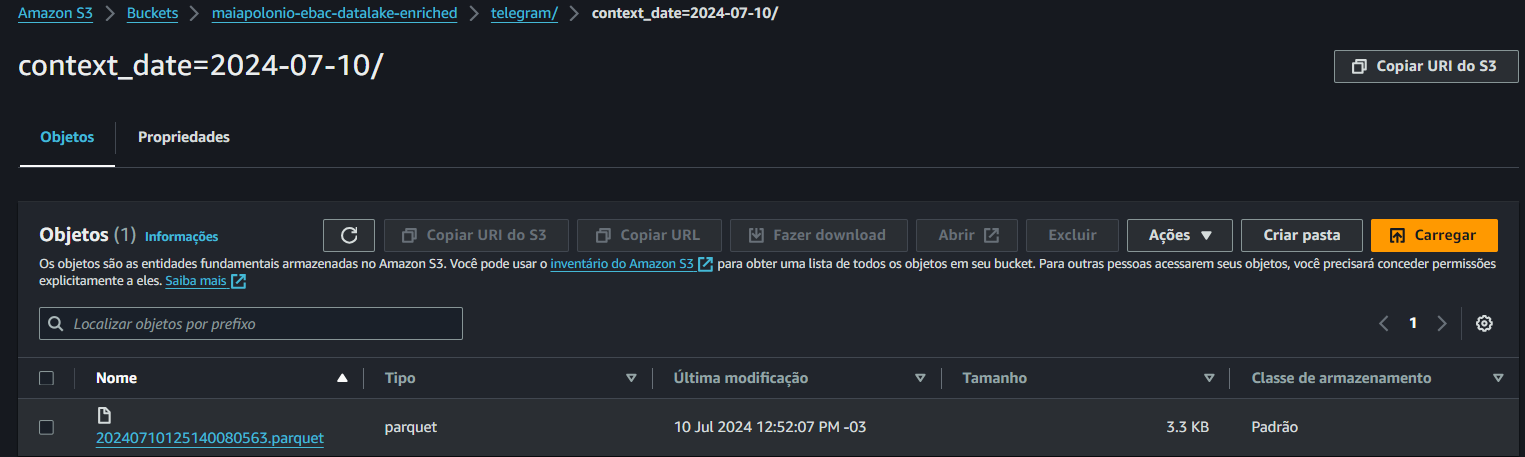

### **6.3. AWS Event Bridge**

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

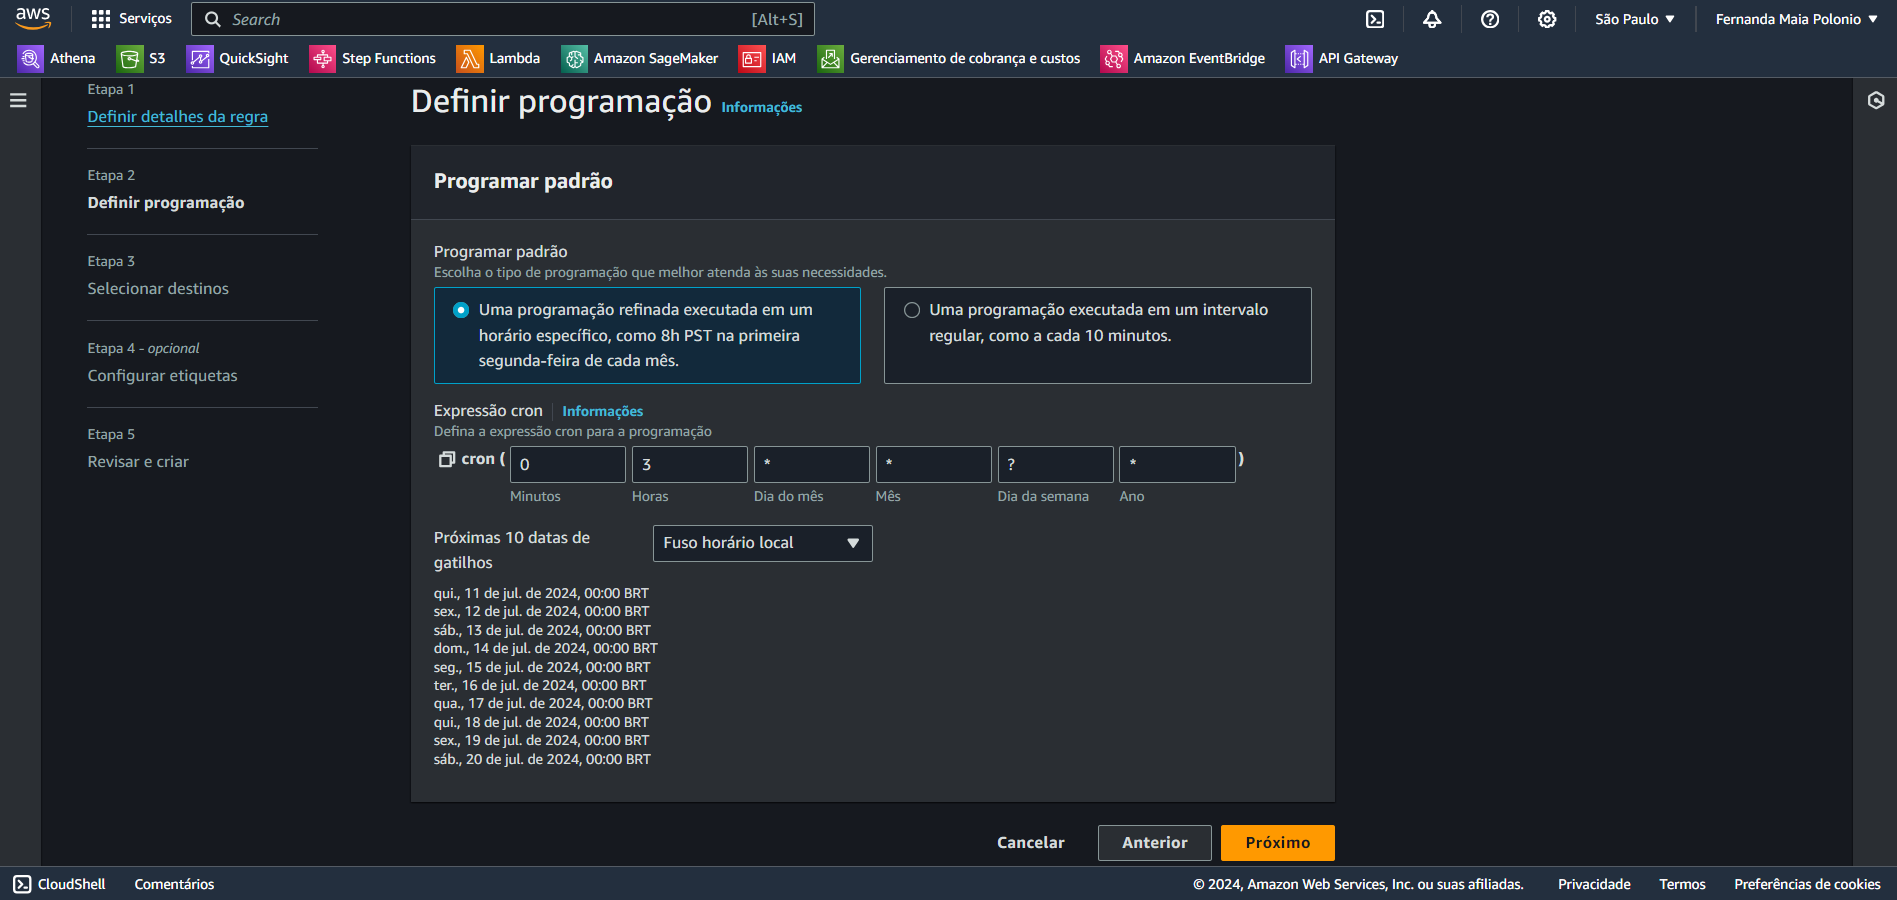

## 7\. Apresentação

A etapa de **apresentação** é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

### **7.1. AWS Athena**

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

**Tabela Criada no Athena**

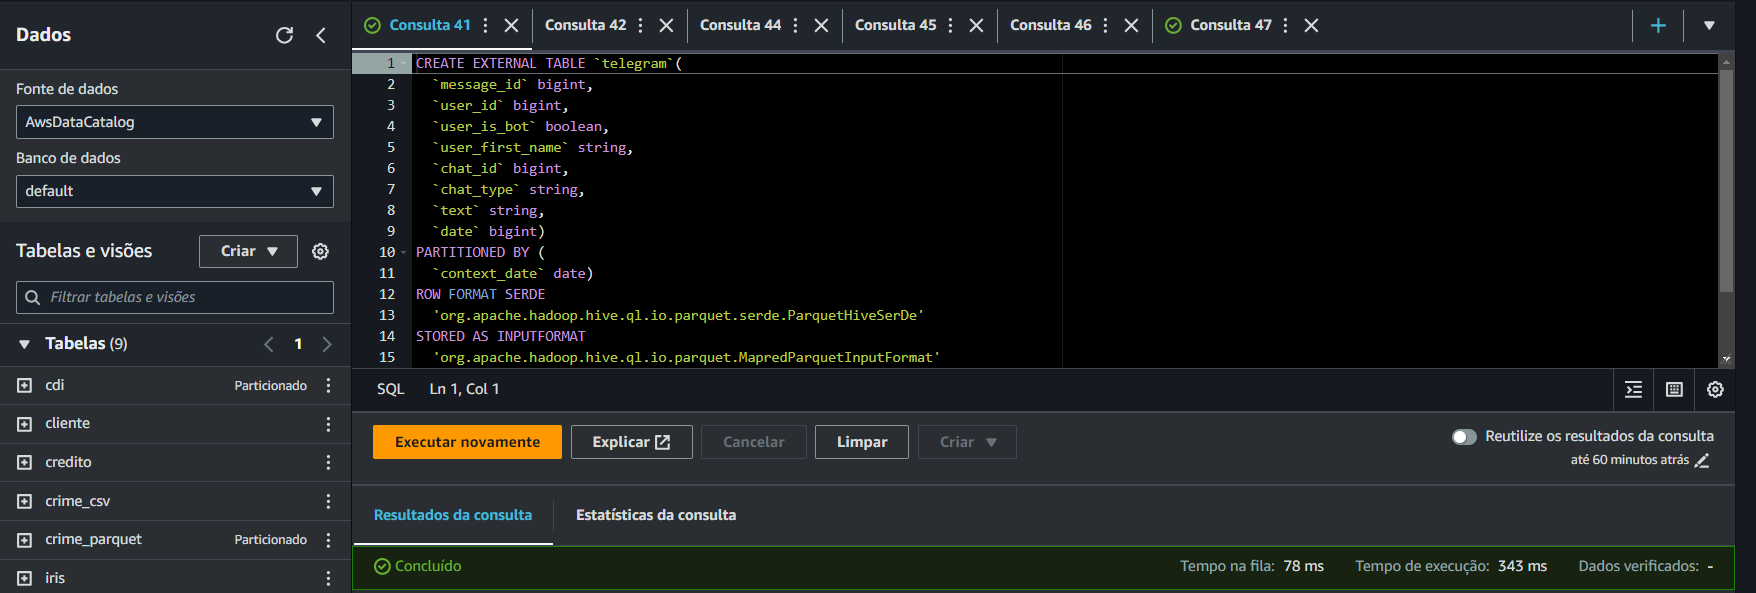

**Adicionando as Partições Disponíveis**

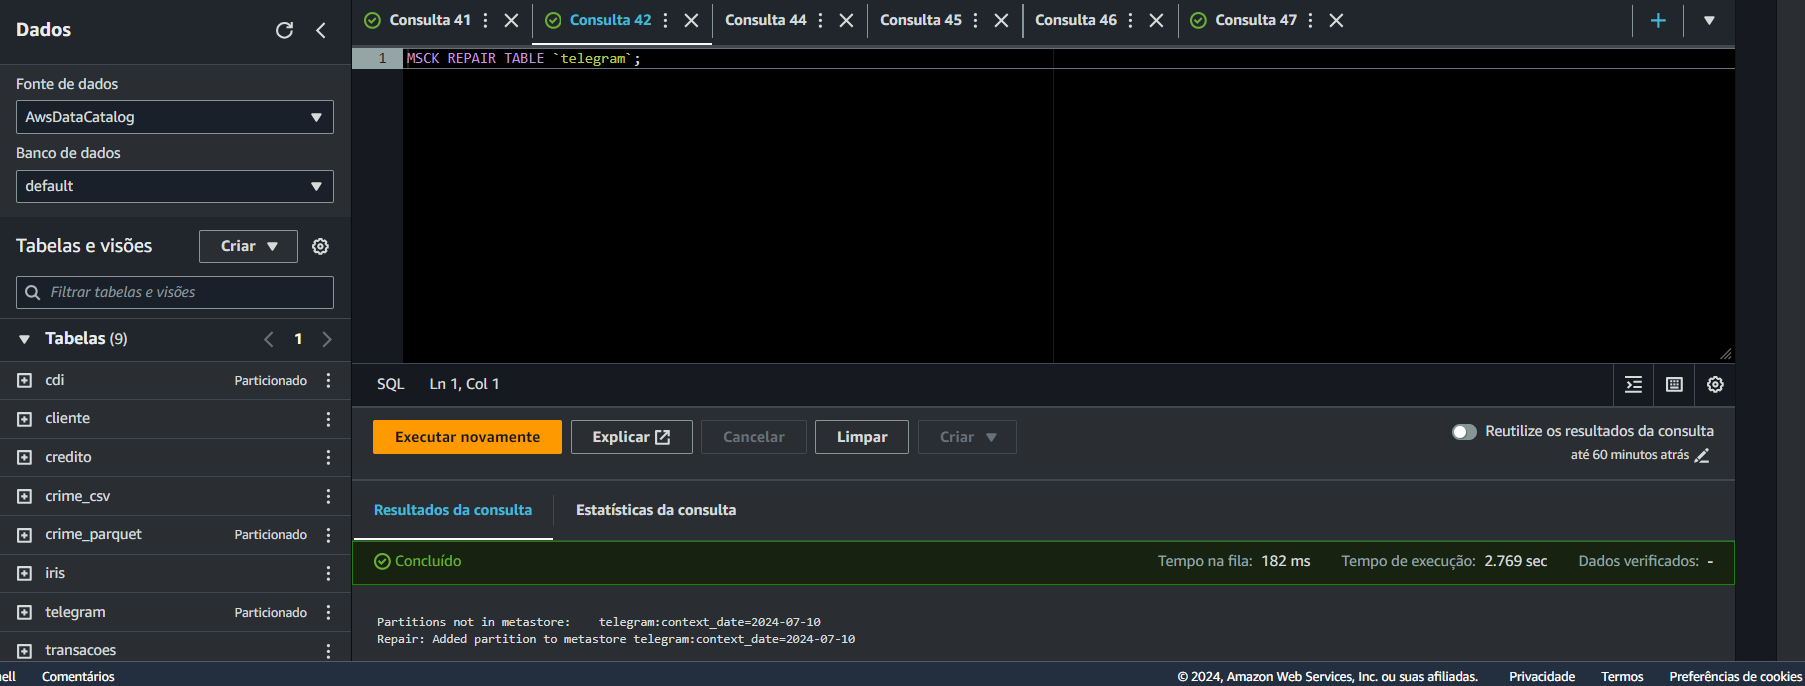

### **7.2. Analytics**

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:

- Quantidade de mensagens por dia.

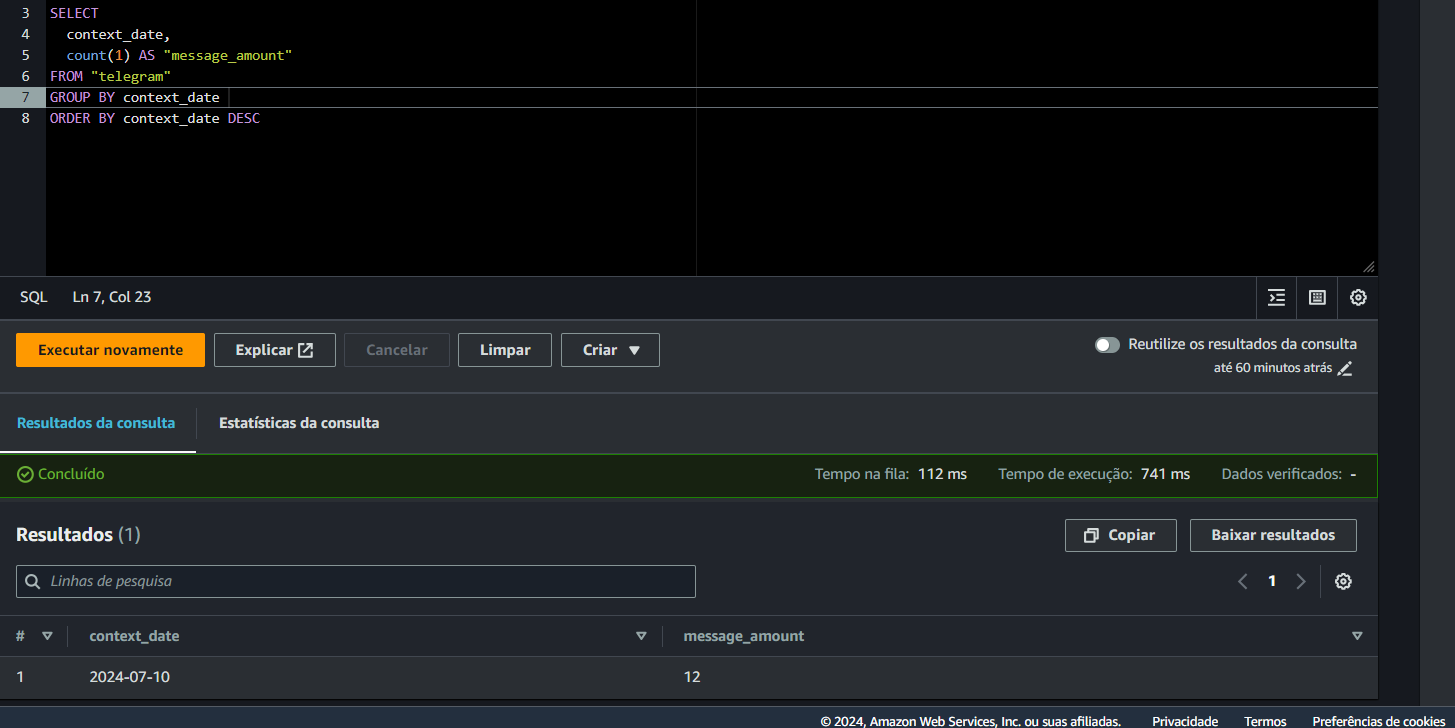

- Quantidade de mensagens por usuário por dia.

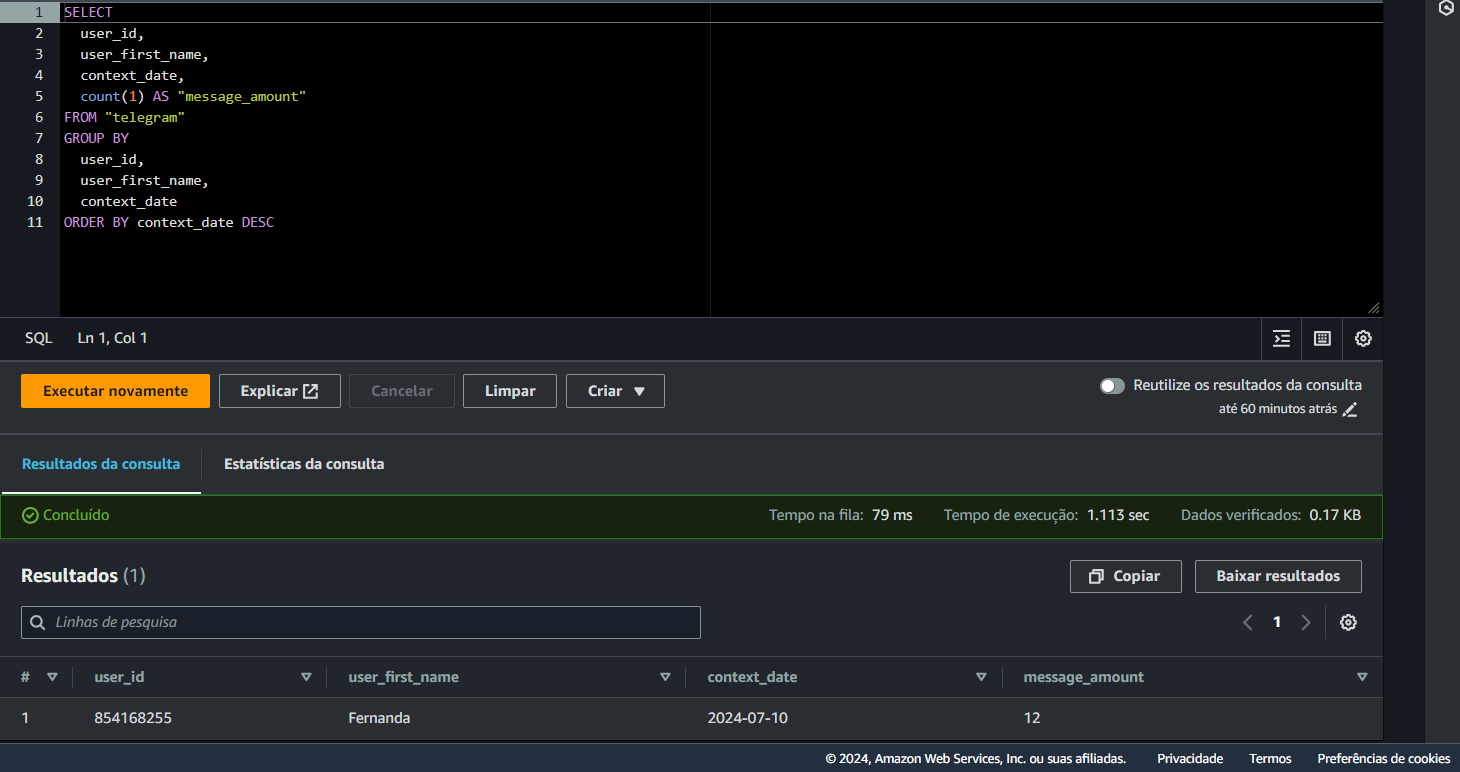

- Média do tamanho das mensagens por usuário por dia.

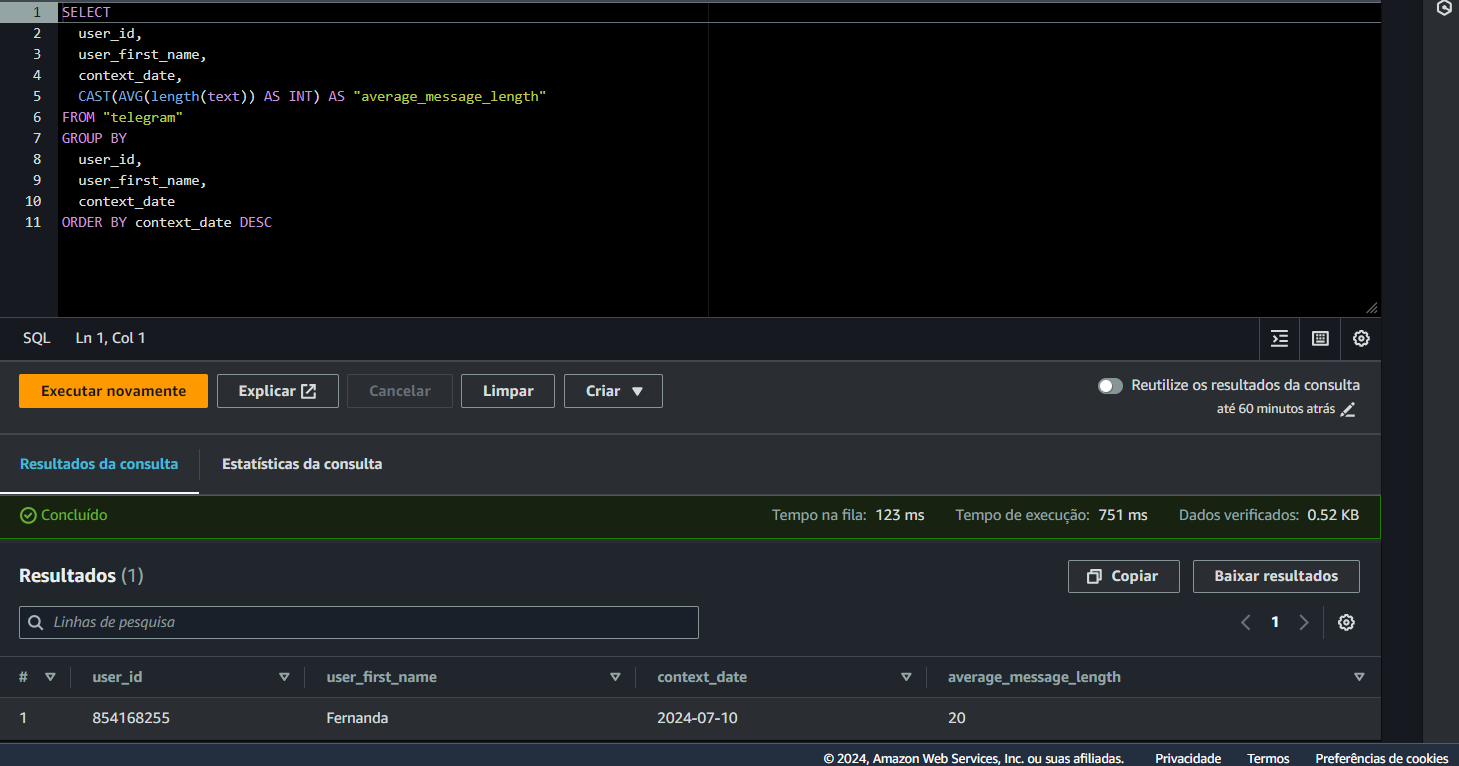

### **8.Conclusão**

O pipeline de dados foi implementado com sucesso, sendo capaz de captar mensagens enviadas pelos usuários no chat do Telegram e processá-las automaticamente em tempo real. Os dados são armazenados de forma organizada, utilizando particionamento para separar os dados brutos dos dados enriquecidos.
A combinação entre chatbots e análise de dados é uma poderosa ferramenta para melhorar a experiência do cliente, otimizar processos internos e impulsionar o crescimento das empresas em todos os setores.